# Support Vector Machine Exercise
In this exercise you will learn about:
1. Implementing SVM from scratch using a sub-gradient method called Pegasos (2011)
2. The effect of imbalance and non-seperable classes on the SVM solution.
3. Pratical SVM in scikit-learn on a simple example including hyper parameter optimization wrapper class to find optimal regularization, loss and multiclass technique.
4. Optional reading material on one class, new probability interpretation of SVM

## 1. Implementing the PEGASOS SVM
We will implement the simplest SVM implementation.
It is based on a paper by Shalev-Shwartz et al (see reading material below).
The essense of the algorithm is copied below from the paper:
![alt text](https://snag.gy/Gpi1Mk.jpg)

Here is a little more deailed explanation (it's recommended to read the full paper).
![alt_text](https://snag.gy/koA0ue.jpg)

1. Implement a class *PegasosSVM* which has parameter $\lambda$ and $T$ and methods *fit* and *predict* and *decision_function* where the latter is the distance from the plane (aka model's output score).
  * **although the above**, here you are required to pad the samples with 1, and not use bias (the separating hyperplane must go through the origin).
  * don't forget labels should be {-1,1} - change them if it is {0,1}
  * don't forget to normalize your features. You can use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to create a pipeline which first standartize features and then learn.
  * decision function is simply the Euclidean distance (with a sign that designates from which side of the decision plane the point is located) from the decision plane to each sample. So, if you query for some point, you will get a positive number if the point is above the plain and negative if it is below it. The value will give you the distance which you can use for a scoring, for example, after you normalize it. If a point is very near to the decision plane it will have a lower score than a point that is farther. Also, if your point is located inside the margins of the model, you may want to treat the score as a probability for assigning the point to one class or another.

2. test your class on the breast cancer database [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), and compare your results to the Native Scikit-learn implementation [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
  * you can use [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

3. Analyze the effect of the hyper parameter $\lambda$ on your training and test error.
  * you can use scikit-learn's `validation_curve`

4. Analyze the learning curve (performance as function of training size)
  * you can use scikit-learn's `learning_curve`

5. *Bonus: Mini-batches* . In the paper, the authors summed the loss over several samples before updating. Extend your class to support mini-batches and analyze the perfomance effect if exists. See more details below

![](https://i.ibb.co/0BGwVz7/1.png)

In [29]:
import numpy as np
import pandas as pd
import random

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve, ValidationCurveDisplay, learning_curve
from sklearn.svm import LinearSVC

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin

In [18]:
class SVM(BaseEstimator, ClassifierMixin):

    def __init__ (self, lambda_param=0.01, n_iters=1000, k=0):
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.k = k


    
    def fit(self, X, y):

        # Transform labels to {-1, 1} if needed
        y = self.transform_labels(y)


        # Add bias to sample vectors
        X = np.c_[np.ones(len(X)), X]
        n_samples, n_features = X.shape


        # Initialize weight vector
        self.w = np.zeros(n_features)

        fac = 0

        if self.k == 0:
            for t in range(1, self.n_iters+1):

                # Choose an index i uniformly random
                i = np.random.choice(n_samples, 1)[0]
                x_i, y_i = X[i], y[i]

                eta = 1 / (self.lambda_param * t)
                fac = (1 - eta * self.lambda_param) * self.w
                penalty = eta * y_i * x_i

                if y_i * np.dot(self.w, x_i) < 1:
                    self.w = fac + penalty
                else:
                    self.w = fac
        else:
            for t in range(1, self.n_iters+1):
                
                # Choose a subset of size k
                sub_i = np.random.choice(n_samples, self.k)
                penalty = 0

                for j in sub_i:
                    x_j, y_j = X[j], y[j]
                    eta = 1 / (self.lambda_param * t)
                    fac = (1 - eta * self.lambda_param) * self.w
                    
                    if y_j * np.dot(self.w, x_j) < 1:
                        penalty = eta * y_j * x_j

                self.w = fac + penalty / self.k

            
            #print(i)
            #print(X[i], y[i])
            #print(f't = {t}')
            #print(f'w = {self.w}')


    
    def transform_labels(self, y):
        unique_labels = np.unique(y)
        
        if np.array_equal(unique_labels, [0, 1]):
            return 2 * y - 1
        elif np.array_equal(unique_labels, [-1, 1]):
            return y
        else:
            raise ValueError("Labels should be either {0, 1} or {-1, 1}.")


    def predict(self, X):
        # Add bias to sample vectors
        X = np.c_[np.ones(len(X)), X]
        y_pred = np.sign(np.dot(X, self.w))
        return y_pred
    
    def score(self, X, y):
        y = self.transform_labels(y)
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    
    def get_params(self, deep=True):
        return {'lambda_param': self.lambda_param, 'n_iters': self.n_iters, 'k': self.k}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    


* **test your class on the breast cancer database, and compare your results to the Native Scikit-learn implementation**

In [5]:
#np.random.seed(11)
data = load_breast_cancer()
X_train = data.data
y_train = data.target

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM())
])

# Use cross_val_score for PEGASOS SVM
cross_val_scores_pegasos = cross_val_score(svm_pipeline, X_train, y_train)

# Use cross_val_score for LinearSVC
linear_svc = LinearSVC(dual='auto')
cross_val_scores_linear_svc = cross_val_score(linear_svc, X_train, y_train)

# Print the cross-validated scores

print("Average Cross-validated score for PEGASOS SVM:", np.mean(cross_val_scores_pegasos))

print("Average Cross-validated score for LinearSVC:", np.mean(cross_val_scores_linear_svc))


Average Cross-validated score for PEGASOS SVM: 0.9789163173420278
Average Cross-validated score for LinearSVC: 0.9508150908244062


**Analyze the effect of the hyper parameter $\lambda$ on your training and test error.**

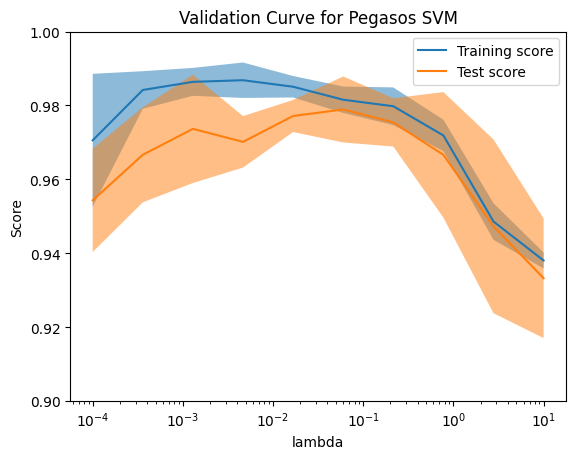

The best lambda is: 0.0599


In [4]:
np.random.seed(42)
param_range = np.logspace(-4, 1, 10)
train_scores, test_scores = validation_curve(svm_pipeline, X_train, y_train, param_name="svm__lambda_param", param_range=param_range)

# Plot validation curve
disp = ValidationCurveDisplay(param_name="svm__lambda_param", param_range=param_range, train_scores=train_scores, test_scores=test_scores, score_name="Score")
disp.plot()
plt.title("Validation Curve for Pegasos SVM")
plt.xlabel("lambda")
plt.ylim(0.9, 1)
plt.legend(["Training score", "Test score"])
plt.show()

# Find the best lambda
mean_test_score = np.mean(test_scores, axis=1)
best_lambda = param_range[np.argmax(mean_test_score)]
print("The best lambda is:",round(best_lambda,4))

* **Analyze the learning curve (performance as function of training size)**

                  Train Accuracy  Test Accuracy  Train Std  Test Std
Samples to train                                                    
45                      0.995556       0.753874   0.015583  0.061890
150                     0.977333       0.959556   0.009350  0.023170
250                     0.977600       0.970129   0.005610  0.015651
354                     0.984181       0.980686   0.006717  0.024584
455                     0.980220       0.977177   0.005449  0.020828


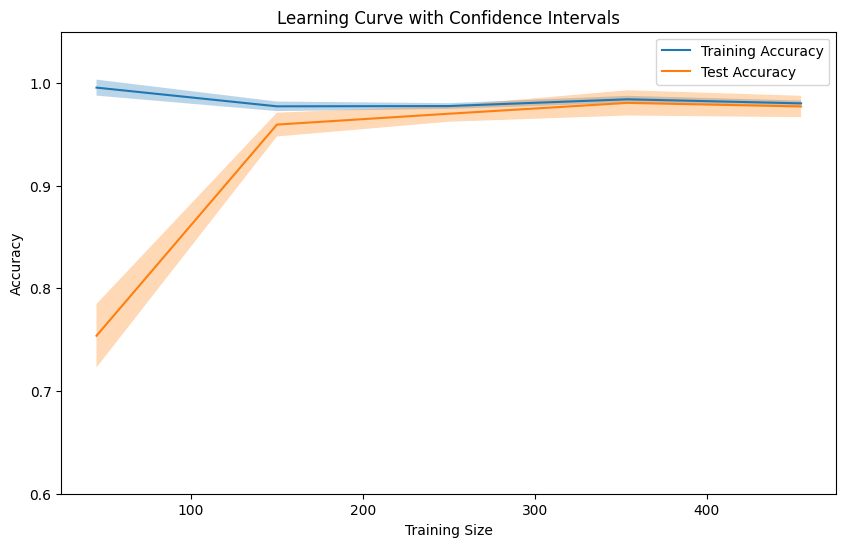

In [13]:
np.random.seed(42)
train_size_abs, train_scores, test_scores = learning_curve(svm_pipeline, X_train, y_train, train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1.]))

# Function to calculate confidence intervals
def calculate_ci(scores):
    mean = np.mean(scores, axis=1)
    std = np.std(scores, axis=1)
    ci_upper = mean + 1.96 * (std / np.sqrt(scores.shape[1]))
    ci_lower = mean - 1.96 * (std / np.sqrt(scores.shape[1]))
    ci = ci_upper - ci_lower
    return ci_lower, ci_upper, ci

# Compute confidence intervals
train_ci_lower, train_ci_upper, train_ci = calculate_ci(train_scores)
test_ci_lower, test_ci_upper, test_ci = calculate_ci(test_scores)

# Print results
data = []
for train_size, cv_train_scores, cv_test_scores, cv_train_ci, cv_test_ci in zip(
        train_size_abs, train_scores, test_scores, train_ci, test_ci):
    data.append([train_size, cv_train_scores.mean(), cv_test_scores.mean(), cv_train_ci.mean(), cv_test_ci.mean()])
columns = ["Samples to train", "Train Accuracy", "Test Accuracy", "Train Std", "Test Std"]
df = pd.DataFrame(data, columns=columns)
df.set_index("Samples to train", inplace=True)
print(df)

# Plotting with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(train_size_abs, np.mean(train_scores, axis=1), label='Training Accuracy')
plt.fill_between(train_size_abs, train_ci_lower, train_ci_upper, alpha=0.3)
plt.plot(train_size_abs, np.mean(test_scores, axis=1), label='Test Accuracy')
plt.fill_between(train_size_abs, test_ci_lower, test_ci_upper, alpha=0.3)
plt.title('Learning Curve with Confidence Intervals')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0.6, 1.05)
plt.show()

The learning curve analysis reveals an initial overfitting at 45 samples, where the model achieves perfect training accuracy but struggles with generalization (test accuracy of 75.4%). With an increase in training size both training and test accuracies improve. After 350 samples the curve reaches a plateau. And further data collection may not significantly improve the model.

* **Bonus: Mini-batches. Extend your class to support mini-batches and analyze the perfomance effect if exists**

In [10]:
np.random.seed(42)
svm_batch_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVM(k=5))
])

svm_batch_scores = cross_val_score(svm_batch_pipeline, X_train, y_train)    
print("Cross-validated scores for Pegasos SVM with batches size 5:",svm_batch_scores.mean())

Cross-validated scores for Pegasos SVM with batches size 5: 0.9754075454122031


Let's check basic and improved algorithms with best lambda 

In [19]:
svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVM(lambda_param=best_lambda))])
cross_val_scores_pegasos = cross_val_score(svm_pipeline, X_train, y_train)
print("Average Cross-validated score for Pegasos SVM:", np.mean(cross_val_scores_pegasos))


svm_batch_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVM(k=5, lambda_param=best_lambda))])
svm_batch_scores = cross_val_score(svm_batch_pipeline, X_train, y_train)    
print("Cross-validated scores for Pegasos SVM with batches size 5:",np.mean(svm_batch_scores))

Average Cross-validated score for Pegasos SVM: 0.9753920198726906
Cross-validated scores for Pegasos SVM with batches size 5: 0.9789007918025151


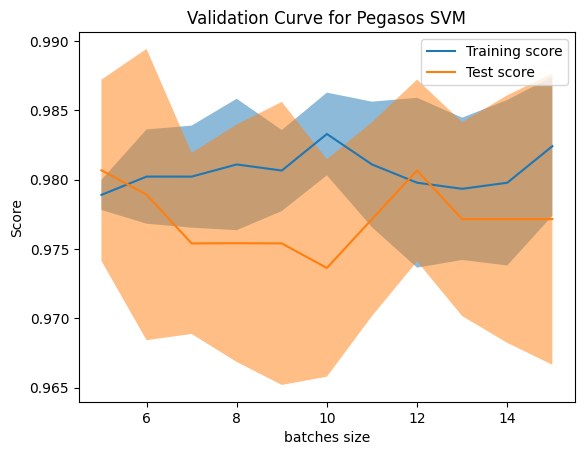

In [23]:
np.random.seed(42)
param_range = np.arange(5, 16, 1)
train_scores, test_scores = validation_curve(svm_batch_pipeline, X_train, y_train, param_name="svm__k", param_range=param_range)

# Plot validation curve
disp = ValidationCurveDisplay(param_name="svm__k", param_range=param_range, train_scores=train_scores, test_scores=test_scores, score_name="Score")
disp.plot()
plt.title("Validation Curve for Pegasos SVM")
plt.xlabel("batches size")
plt.legend(["Training score", "Test score"])
plt.show()


## 2. The importance of class weighting in SVM
When classes are imbalance and not seperable, SVM might result in non intuitive solution.

To see this we created for you a function `make_data` which generates a two dimensional dataset with `n_samples=1000` where a fraction `imbalance=0.1` is labeled `0` and the rest `1`. The distribution of $x$ given $y=0$ or $y=1$ is gaussian with std 0.5 or 2, respectively and that the centers are at $x_1=0$ and $x_2=-d/2$ and $x_2=d/2$, respectively. In other words,  
$$
p(x|y) = \mathcal{N}(\mu=(±d/2,0),\,\sigma=1/2+3/2\times y)
$$
and
$$
p(y=0) = 0.1
$$.

TODO:
1. For `d=10` and `d=2` plot the scatter plot of the data. Where would you think the SVM hyperplane will lie?

2. Now, for each of these d, draw on top of the scatter the seperation hyperplane of the built-in LinearSVC in scikit-learn.

To plot the hyperplane, note that the fitted model has the `coef_` and `intercept_` properties.
Add also the `accuracy` and the `balanced_accuracy` metrics to the plot title.

3. repeat the experiment but now set the `class_weight` to be `balanced`.
The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

Explain what was the problem and how changing class weight solved it.


## Answer #

In [25]:
# a function make_data which generates a two dimensional dataset with n_samples=1000 where a fraction imbalance=0.1 is
# labeled 0 and the rest 1. The distribution of  𝑥  given  𝑦=0  or  𝑦=1  is gaussian with std 0.5 or 2, respectively and that
# the centers are at  𝑥1=0  and  𝑥2=−𝑑/2  and  𝑥2=𝑑/2 ,

def make_data(d, imbalance=0.1):
    n_samples=1000
    X = np.zeros((n_samples, 2))
    y = np.random.binomial(1, 1-imbalance, n_samples)
    size_0 = np.sum(y==0)
    size_1 = np.sum(y==1)
    X[y==0,0] = np.random.normal(loc=0, scale=0.5, size=size_0)
    X[y==1,0] = np.random.normal(loc=0, scale=2, size=size_1)
    X[y==0,1] = np.random.normal(loc=-d/2, scale=0.5, size=size_0)
    X[y==1,1] = np.random.normal(loc=d/2, scale=2, size=size_1)
    return X, y

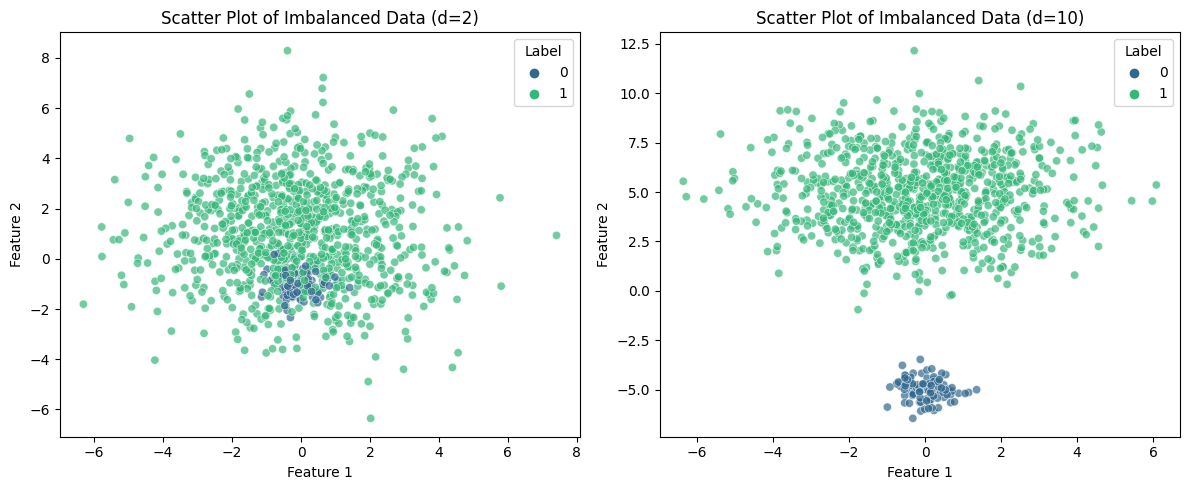

In [35]:

def plot_data(X, y, d, ax):
    data = {'feature_1': X[:, 0], 'feature_2': X[:, 1], 'label': y}
    df = pd.DataFrame(data)

    sns.scatterplot(x='feature_1', y='feature_2', hue='label', data=df, palette='viridis', marker='o', alpha=0.7, ax=ax)
    ax.set_title(f'Scatter Plot of Imbalanced Data (d={d})')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend(title='Label', loc='upper right')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for d=2
d2 = 2
X_d2, y_d2 = make_data(d2)
plot_data(X_d2, y_d2, d2, ax=axes[0])

# Plot for d=10
d10 = 10
X_d10, y_d10 = make_data(d10)
plot_data(X_d10, y_d10, d10, ax=axes[1])

# Adjust layout
plt.tight_layout()
plt.show()


In [36]:
linear_svc = LinearSVC(dual='auto')

linear_svc.fit(X_d10, y_d10)
linear_svc.coef_

array([[-0.12274579,  0.55092588]])

## 3. SVM hyperparameter search
Machine learning pipelines in general and models in particular has several hyperparametrs that we currently do not know how to optimize.
Instead, researcher use grid search or random search techniques to find the optimal hyper parameters.
In this exercise you are requested to compare between default params model and a model which internally optimize for these hyper parameters.
Luckily, scikit-learn already has a ready class for doing that called `GridSearchCV`. Use the latter class to check all the combination of the following hyper parameters:
* `'multi_class':['ovr', 'crammer_singer']`
* `'loss':['hinge', 'squared_hinge']`
* `'C': np.logspace(-3,3,10)`

Compare the accuracy of the model to a default `LinearSVC` model with no hyper parameter optimization in terms of accuracy.

Note: Recall, that hyper parameter search is a learning procedure by itself, thus one should not use test data for the process.

To do this you can use the handy `cross_val_score` function.

Use the cancer dataset for this question


## Answer #

## 4. Classifying Checkerboard with SVM (20)
In this exercise you will try to choose a kernel for classifying a checkerboard labeled data.

* Use the `checkboard` function below to generate
your training set (1000 or 2000 samples) and a testing set (as much as you like). As you can see the function generates samples in 2D and label them according to a 3 × 3 checkerboard (obviously linear separation will not do the job here). Python’s scatter in the might come in handy.

* Use SVM to find a good linear separation in high dimensional feature space using the polynomial or the Gaussian (RBF) kernel.    You should evaluate for both models the best parameters to use. Explain how do you evalute each model?
   - For polynomial kernel, estimate which degree to use
   - For RBF, estimate which standard deviation to use
   - For both models, also choose which regularization parameter is best to use

* For the best model of each kernel, plot a scatter plot of the training patterns (colored by label) and mark the support vectors as well. Which model would you choose to use in this case?

* In addition, if you are curious, you can try and think of a way to plot the separating hyper-surface (curve in this case), the margin, and the testing set (to check which points are misclassified).

In [ ]:
import numpy as np
def checkerboard(n):
    """
    CHECKERBOARD Sample points from a 3x3 checkerboard in 2D
    """
    X = np.random.rand(n,2); # samples dimension N = 2
    l = np.mod(np.ceil(X*3), 2);
    y0 = np.logical_xor(l[:,0], l[:,1])
    y = y0*2-1 # {-1,+1}
    return X, y

In [ ]:
# Usage sample
import matplotlib.pyplot as plt
X, y = checkerboard(3000)
plt.figure(figsize=(3,3))
plt.scatter(X[y==1,0], X[y==1,1], c='r', s=3)
plt.scatter(X[y==-1,0], X[y==-1,1], c='b', s=3)
plt.xlim([0,1])
plt.ylim([0,1]);

## Optional Reading Materials
1. Shalev-Shwartz, S., Singer, Y., Srebro, N., & Cotter, A. (2011). Pegasos: Primal estimated sub-gradient solver for svm. Mathematical programming, 127(1), 3-30. [[pdf](http://www.ee.oulu.fi/research/imag/courses/Vedaldi/ShalevSiSr07.pdf)]

2. Schölkopf, B., Williamson, R. C., Smola, A. J., Shawe-Taylor, J., & Platt, J. C. (2000). Support vector method for novelty detection. In Advances in neural information processing systems (pp. 582-588). [[pdf](http://papers.nips.cc/paper/1723-support-vector-method-for-novelty-detection.pdf)]

3. Livni, R., Crammer, K. & Globerson, A.. (2012). A Simple Geometric Interpretation of SVM using Stochastic Adversaries. Proceedings of the Fifteenth International Conference on Artificial Intelligence and Statistics, in PMLR 22:722-730. [[pdf](http://proceedings.mlr.press/v22/livni12/livni12.pdf)]

